# Anomaly Detection on BattleGround Data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random

import pandas as pd
import numpy as np

In [3]:
import torch
import torch.nn as nn
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [4]:
from tqdm import tqdm

In [5]:
data_path = '/content/drive/MyDrive/인공지능시스템/fps_anomi_samples.csv'

# 데이터 로드
data_origin = pd.read_csv(data_path)
data_ex = data_origin[:1000000]

# 선택된 열에 대해 표준화
selected_df = data_ex.iloc[:, 4:]
selected_mean = selected_df.mean()
selected_std = selected_df.std()

# 표준화 수행
standardized_data = (selected_df - selected_mean) / selected_std

# 이제 standardized_data를 DataLoader에 사용할 수 있습니다.


In [6]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(24, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 24),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [7]:
batch_size = 2000
lr = 1e-4         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9
epochs = 20

In [8]:
class Loader(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super(Loader, self).__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        tensor_row = torch.tensor(row.values, dtype=torch.float)
        return tensor_row

In [9]:
# Loader 인스턴스화
train_set = Loader(standardized_data)

# DataLoader 설정
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [10]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [11]:
# 모델을 학습 모드로 설정
model.train()
start = time.time()

# 에포크별로 반복
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0

    # tqdm을 사용하여 훈련 데이터 로더를 감쌉니다.
    train_loader = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

    # 배치별로 반복
    for data in train_loader:
        # 데이터를 디바이스에 로드
        data = data.to(device)

        # 모델에 데이터를 전달하여 결과를 얻음
        sample = model(data)

        # 손실 계산
        loss = criterion(data, sample)

        # 역전파 수행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 누적 손실 업데이트
        running_loss += loss.item()

        # tqdm 업데이트
        train_loader.set_postfix(loss=loss.item())

    # 에포크 손실 계산
    epoch_loss = running_loss / len(train_set)
    metrics['train_loss'].append(epoch_loss)

    ep_end = time.time()
    print('-----------------------------------------------')
    print(f'[EPOCH] {epoch+1}/{epochs}\n[LOSS] {epoch_loss}')
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end - ep_start)))

end = time.time()
print('-----------------------------------------------')
print(f'[System Complete: {timedelta(seconds=end - start)}]')


Epoch 1/20: 100%|██████████| 500/500 [01:55<00:00,  4.32batch/s, loss=1.05]


-----------------------------------------------
[EPOCH] 1/20
[LOSS] 0.0005002856416702271
Epoch Complete in 0:01:55.837699


Epoch 2/20: 100%|██████████| 500/500 [01:46<00:00,  4.70batch/s, loss=1.07]


-----------------------------------------------
[EPOCH] 2/20
[LOSS] 0.0005002814790010452
Epoch Complete in 0:01:46.373403


Epoch 3/20: 100%|██████████| 500/500 [01:47<00:00,  4.64batch/s, loss=0.982]


-----------------------------------------------
[EPOCH] 3/20
[LOSS] 0.0005002773993015289
Epoch Complete in 0:01:47.786860


Epoch 4/20: 100%|██████████| 500/500 [01:45<00:00,  4.74batch/s, loss=0.992]


-----------------------------------------------
[EPOCH] 4/20
[LOSS] 0.0005002733785510063
Epoch Complete in 0:01:45.446295


Epoch 5/20: 100%|██████████| 500/500 [01:48<00:00,  4.62batch/s, loss=1.01]


-----------------------------------------------
[EPOCH] 5/20
[LOSS] 0.0005002694153785705
Epoch Complete in 0:01:48.177714


Epoch 6/20: 100%|██████████| 500/500 [01:46<00:00,  4.71batch/s, loss=0.957]


-----------------------------------------------
[EPOCH] 6/20
[LOSS] 0.0005002655117511749
Epoch Complete in 0:01:46.091262


Epoch 7/20: 100%|██████████| 500/500 [01:48<00:00,  4.60batch/s, loss=0.953]


-----------------------------------------------
[EPOCH] 7/20
[LOSS] 0.0005002616682052612
Epoch Complete in 0:01:48.803037


Epoch 8/20: 100%|██████████| 500/500 [01:46<00:00,  4.70batch/s, loss=1.02]


-----------------------------------------------
[EPOCH] 8/20
[LOSS] 0.0005002578774690628
Epoch Complete in 0:01:46.293498


Epoch 9/20: 100%|██████████| 500/500 [01:49<00:00,  4.57batch/s, loss=1.11]


-----------------------------------------------
[EPOCH] 9/20
[LOSS] 0.00050025414198637
Epoch Complete in 0:01:49.506616


Epoch 10/20: 100%|██████████| 500/500 [01:48<00:00,  4.60batch/s, loss=1.03]


-----------------------------------------------
[EPOCH] 10/20
[LOSS] 0.0005002504598498345
Epoch Complete in 0:01:48.791171


Epoch 11/20: 100%|██████████| 500/500 [01:48<00:00,  4.60batch/s, loss=1.14]


-----------------------------------------------
[EPOCH] 11/20
[LOSS] 0.0005002468335032463
Epoch Complete in 0:01:48.703555


Epoch 12/20: 100%|██████████| 500/500 [01:49<00:00,  4.56batch/s, loss=0.967]


-----------------------------------------------
[EPOCH] 12/20
[LOSS] 0.0005002432588338851
Epoch Complete in 0:01:49.618342


Epoch 13/20: 100%|██████████| 500/500 [01:46<00:00,  4.69batch/s, loss=0.975]


-----------------------------------------------
[EPOCH] 13/20
[LOSS] 0.0005002397348284721
Epoch Complete in 0:01:46.716954


Epoch 14/20: 100%|██████████| 500/500 [01:47<00:00,  4.63batch/s, loss=1.02]


-----------------------------------------------
[EPOCH] 14/20
[LOSS] 0.0005002362640500068
Epoch Complete in 0:01:47.912235


Epoch 15/20: 100%|██████████| 500/500 [01:46<00:00,  4.68batch/s, loss=0.982]


-----------------------------------------------
[EPOCH] 15/20
[LOSS] 0.0005002328413724899
Epoch Complete in 0:01:46.911542


Epoch 16/20: 100%|██████████| 500/500 [01:49<00:00,  4.55batch/s, loss=0.948]


-----------------------------------------------
[EPOCH] 16/20
[LOSS] 0.0005002294629216194
Epoch Complete in 0:01:49.907447


Epoch 17/20: 100%|██████████| 500/500 [01:49<00:00,  4.56batch/s, loss=1.06]


-----------------------------------------------
[EPOCH] 17/20
[LOSS] 0.0005002261255979538
Epoch Complete in 0:01:49.594351


Epoch 18/20: 100%|██████████| 500/500 [01:47<00:00,  4.63batch/s, loss=1.02]


-----------------------------------------------
[EPOCH] 18/20
[LOSS] 0.0005002228488922119
Epoch Complete in 0:01:47.921689


Epoch 19/20: 100%|██████████| 500/500 [01:48<00:00,  4.61batch/s, loss=0.995]


-----------------------------------------------
[EPOCH] 19/20
[LOSS] 0.000500219623029232
Epoch Complete in 0:01:48.421944


Epoch 20/20: 100%|██████████| 500/500 [01:45<00:00,  4.74batch/s, loss=0.984]

-----------------------------------------------
[EPOCH] 20/20
[LOSS] 0.0005002164409160614
Epoch Complete in 0:01:45.513532
-----------------------------------------------
[System Complete: 0:36:04.343329]


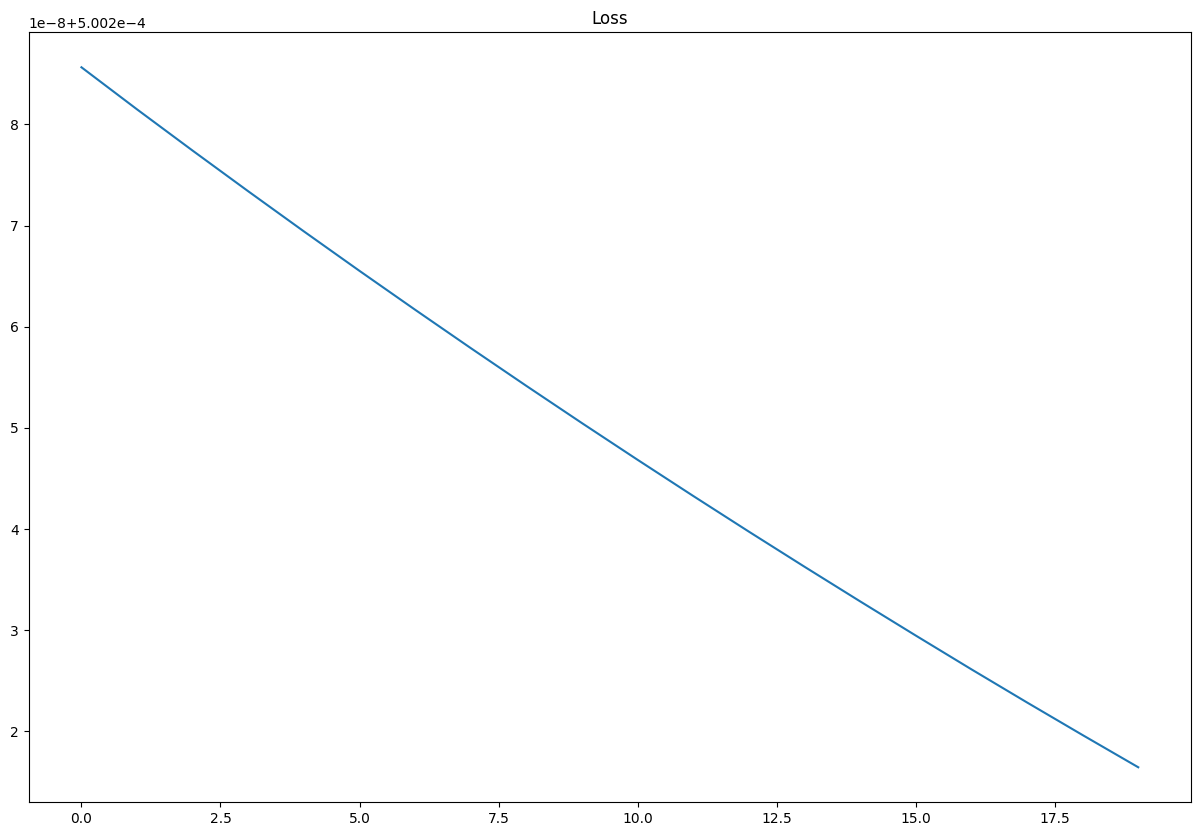

In [12]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 데이터를 텐서로 변환하고 GPU로 이동 (메모리 크기에 따라 조절 필요)
data_tensor = torch.tensor(standardized_data.values, dtype=torch.float).to(device)

# TensorDataset과 DataLoader 사용
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=2000, shuffle=False)

model.eval()
loss_dist = []

# DataLoader를 사용하여 배치 처리
for data_batch in tqdm(data_loader, desc="Evaluating", unit="batch"):
    data_batch = data_batch[0].to(device)
    with torch.no_grad():
        sample = model(data_batch)
        loss = criterion(data_batch, sample)
        loss_dist.extend(loss.item() for _ in range(data_batch.size(0)))


Evaluating: 100%|██████████| 500/500 [00:21<00:00, 23.05batch/s]


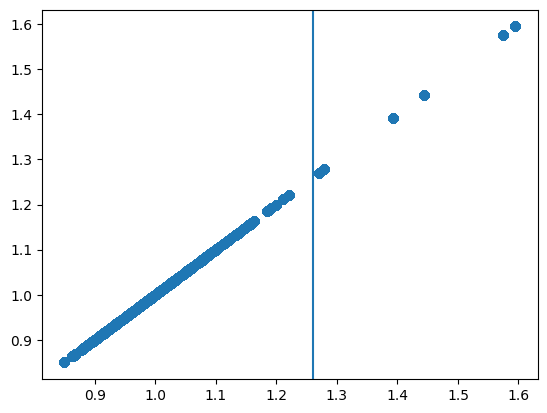

In [18]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(1.26, 0.0, 1)

<ipython-input-19-ccb32dba0353>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loss_dist,bins=100,kde=True, color='blue')


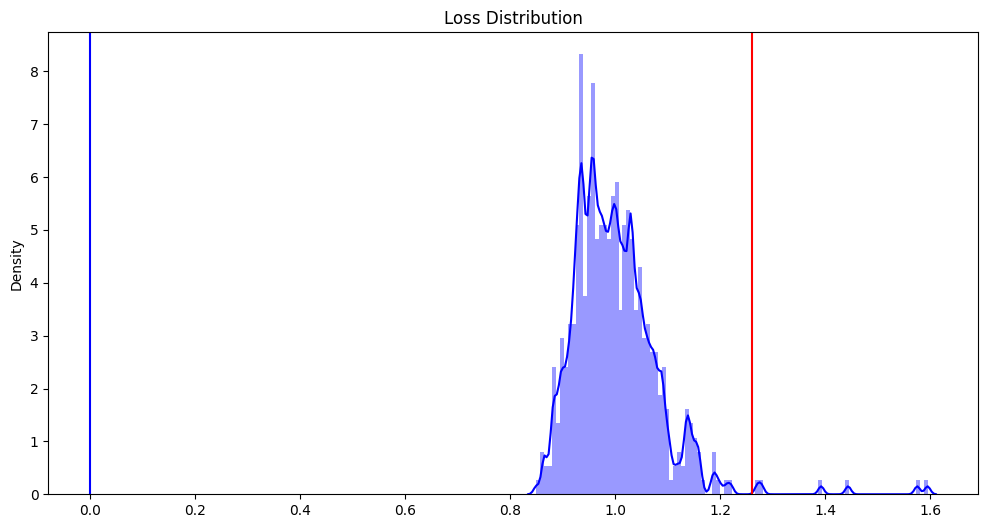

In [19]:
lower_threshold = 0.0
upper_threshold = 1.26
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [21]:
anomalous_ids = []

# 손실 값과 원본 데이터셋의 인덱스를 함께 순회
for i, loss in enumerate(loss_dist):
    if loss >= upper_threshold:
        # 손실이 임계값 이상인 경우, 해당 데이터 포인트의 사용자 ID를 저장
        anomalous_ids.append(data_origin.iloc[i]['Id'])

# 찾아낸 이상치 사용자 ID 출력
print("Anomalous User IDs:", anomalous_ids)
print(len(anomalous_ids))

Anomalous User IDs: [452743.0, 452744.0, 452745.0, 452746.0, 452747.0, 452748.0, 452749.0, 452750.0, 452751.0, 452752.0, 452753.0, 452754.0, 452755.0, 452756.0, 452757.0, 452758.0, 452759.0, 452760.0, 452761.0, 452762.0, 452763.0, 452764.0, 452765.0, 452766.0, 452767.0, 452768.0, 452769.0, 452770.0, 452771.0, 452772.0, 452773.0, 452774.0, 452775.0, 452776.0, 452777.0, 452778.0, 452779.0, 452780.0, 452781.0, 452782.0, 452783.0, 452784.0, 452785.0, 452786.0, 452787.0, 452788.0, 452789.0, 452790.0, 452791.0, 452792.0, 452793.0, 452794.0, 452795.0, 452796.0, 452797.0, 452798.0, 452799.0, 452800.0, 452801.0, 452802.0, 452803.0, 452804.0, 452805.0, 452806.0, 452807.0, 452808.0, 452809.0, 452810.0, 452811.0, 452812.0, 452813.0, 452814.0, 452815.0, 452816.0, 452817.0, 452818.0, 452819.0, 452820.0, 452821.0, 452822.0, 452823.0, 452824.0, 452825.0, 452826.0, 452827.0, 452828.0, 452829.0, 452830.0, 452831.0, 452832.0, 452833.0, 452834.0, 452835.0, 452836.0, 452837.0, 452838.0, 452839.0, 452840.0,